In [ ]:
!pip install kwant

     |████████████████████████████████| 1.6 MB 4.4 MB/s 
  Created wheel for kwant: filename=kwant-1.4.3-cp37-cp37m-linux_x86_64.whl size=3691037 sha256=691b79cfe7af1edc47480b36617d643a7ff0a397df4fd9851d693a18d2ec68d5
  Stored in directory: /root/.cache/pip/wheels/d6/2d/93/6f395cd3f0798d7d9e161dce1c8b8c8bbd04d4547763c926de
  Created wheel for tinyarray: filename=tinyarray-1.2.4-cp37-cp37m-linux_x86_64.whl size=227977 sha256=97511a4e06c4065e271c7a7998b4cdc83c10a3369247d0673954e2935124e57d
  Stored in directory: /root/.cache/pip/wheels/85/c6/1c/6939e2931cfbff5df75758a06084bf67171b640ebdf5febd35
Successfully built kwant tinyarray


In [2]:
import kwant
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy as scp
import numpy as np
import scipy
from kwant.physics import dispersion

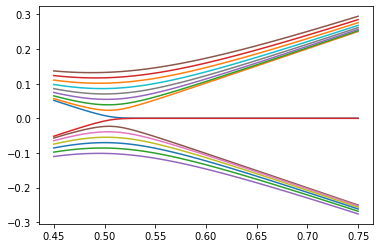

In [105]:
L = 200
# Building SSH model
def ssh_model(t_1 = 1, t_2 = 1, L = L, return_only_ham = 1):
    
    syst = kwant.Builder()
    a = 1
    lat = kwant.lattice.chain(a)

    # Define the scattering region
    for n in range(L):
        syst[lat(n)] = 0

    # Left hopping
    for n in range(L):
        if n%2:
            syst[lat(n-1), lat(n)] = t_1

    # Right hopping
    for n in range(1,L):      
        if not n%2:
            syst[lat(n-1), lat(n)] = t_2

    #kwant.plot(syst)
    syst = syst.finalized()
    
    if(return_only_ham):
        return syst.hamiltonian_submatrix(sparse=True)
    else:
        return syst.hamiltonian_submatrix(sparse=False)

def find_continuator(w: list, next_vectors: list) -> int:
    max_product = np.dot(w, next_vectors[0])
    max_index = 0
    
    for i in range(len(next_vectors)):
        product = np.abs(np.dot(w, next_vectors[i]))
        if(product > max_product):
            max_product = product
            max_index = i
    return max_index

def plot_probability(k_tab: list, eig_number: int, t1 = 0.5, show_unsorted = False) -> None:
    e_val_matrix = np.empty(shape = (len(k_tab), eig_number))
    e_vec_matrix = np.empty(shape = (len(k_tab), eig_number, L), dtype=complex)
    
    for i in range(len(k_tab)):
        t2 = k_tab[i]
        ham = ssh_model(t1, t2)
        e_val, e_vec = scipy.sparse.linalg.eigsh(ham, k=eig_number, sigma=0.01, which='LM', return_eigenvectors=True)
        
        e_val_matrix[i] = e_val
        for j in range(eig_number):
            e_vec_matrix[i,j] = e_vec[:,j]
            e_vec_matrix[i,j] = e_vec_matrix[i,j]/np.sqrt(np.dot(e_vec_matrix[i,j],e_vec_matrix[i,j]))
            
            
    for j in range(eig_number):
        pasek = [e_val_matrix[0, j]]
        wektory = [e_vec_matrix[0, j]]

        for i in range(0, len(k_tab)-1):
            index = find_continuator(wektory[i], e_vec_matrix[i+1])
            wektory.append(e_vec_matrix[i+1, index])
            pasek.append(e_val_matrix[i+1, index])
        

        plt.plot(k_tab, pasek, label=j)
        if(show_unsorted):
            plt.scatter(k_tab, e_val_matrix[:, j], marker='.')
    
k = np.linspace(0.45, 0.75, 50) # Range of k we want to plot
energies_number = 16 # Number of energy bands to show
plot_probability(k, energies_number)
#plt.xlim(0.25,0.75)
#plt.ylim(-0.5,0.5)
plt.savefig("SSH_spectrum_sort.pdf")
plt.show()